# machine.ipynb

This analysis applies machine learning to predict transaction-level profit using the Superstore dataset. We develop two complementary models:
1. **Regression model** to predict HOW MUCH profit a transaction will generate
2. **Classification model** to predict WHETHER a transaction will be profitable (positive profit)

Both models undergo rigorous cross-validation to ensure reliability.

<br>
<br>

In [54]:
from IPython.display import display,Markdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
import seaborn as sns


RANDOM_STATE = 42


In [55]:
def display_title(s, pref='Figure', num=1, center=False):
    ctag = 'center' if center else 'p'
    s    = f'<{ctag}><span style="font-size: 1.2em;"><b>{pref} {num}</b>: {s}</span></{ctag}>'
    if pref=='Figure':
        s = f'{s}<br><br>'
    else:
        s = f'<br><br>{s}'
    display( Markdown(s) )

In [56]:
def analyze_profit_distribution(y):
    print("="*60)
    print("ANALYSIS OF TARGET VARIABLE (Profit)")
    print("="*60)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Profit')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Profit')
    axes[0].axvline(x=0, color='red', linestyle='--', label='Break-even')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].boxplot(y, vert=False)
    axes[1].set_xlabel('Profit')
    axes[1].set_title('Boxplot of Profit')
    axes[1].grid(True, alpha=0.3)

    from scipy import stats
    stats.probplot(y, dist="norm", plot=axes[2])
    axes[2].set_title('Q-Q Plot (vs Normal Distribution)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n Statistics:")
    print(f"   Mean: ${y.mean():.2f}")
    print(f"   Std: ${y.std():.2f}")
    print(f"   Min: ${y.min():.2f}")
    print(f"   Max: ${y.max():.2f}")
    print(f"   Skewness: {y.skew():.2f} (>1 or <-1 means highly skewed)")
    print(f"   Kurtosis: {y.kurtosis():.2f} (normal = 0)")

    neg_pct = (y <= 0).mean() * 100
    print(f"   Negative profits: {neg_pct:.1f}% of transactions")

    mean = y.mean()
    std = y.std()
    outliers_mask = (y < mean - 3*std) | (y > mean + 3*std)
    outliers_pct = outliers_mask.mean() * 100
    print(f"   Outliers (>3σ): {outliers_mask.sum()} ({outliers_pct:.1f}%)")

    return outliers_mask

def remove_extreme_outliers(df, y, n_std=4):
    mean = y.mean()
    std = y.std()

    lower_bound = mean - n_std * std
    upper_bound = mean + n_std * std

    mask = (y >= lower_bound) & (y <= upper_bound)

    print(f"\n Removing outliers beyond {n_std}σ:")
    print(f"   Lower bound: ${lower_bound:.2f}")
    print(f"   Upper bound: ${upper_bound:.2f}")
    print(f"   Keeping {mask.sum()}/{len(y)} samples ({mask.sum()/len(y)*100:.1f}%)")

    return df[mask].copy()

def create_interaction_features(df):
    df = df.copy()

    if 'Sales' in df.columns and 'Discount' in df.columns:
        df['Sales_Discount_interaction'] = df['Sales'] * df['Discount']
        print("Created: Sales × Discount interaction")

    if 'Sales' in df.columns and 'Quantity' in df.columns:
        df['Avg_price_per_unit'] = df['Sales'] / (df['Quantity'] + 1e-10)
        print("Created: Average price per unit")

    if 'Discount' in df.columns and 'Quantity' in df.columns:
        df['Total_discount_amount'] = df['Sales'] * df['Discount']
        print("Created: Total discount amount")

    return df

def engineer_target_variable(df):
    df = df.copy()

    if 'Sales' in df.columns and 'Profit' in df.columns:
        df['Profit_margin'] = df['Profit'] / (df['Sales'] + 1e-10) * 100
        print("Created: Profit margin (%)")

    if 'Profit' in df.columns:
        min_profit = df['Profit'].min()
        constant = abs(min_profit) + 1 if min_profit <= 0 else 0
        df['Profit_log'] = np.log(df['Profit'] + constant) if constant > 0 else np.log(df['Profit'] + 1e-10)

    return df

In [57]:
%run parse_data.ipynb

df.head()


,Profit,Sales,Quantity,Discount,Category,Sub-Category,Region,Segment,Ship Mode
0,41.9136,261.9600,2,0.00,Furniture,Bookcases,South,Consumer,Second Class
1,219.5820,731.9400,3,0.00,Furniture,Chairs,South,Consumer,Second Class
2,6.8714,14.6200,2,0.00,Office Supplies,Labels,West,Corporate,Second Class
3,-383.0310,957.5775,5,0.45,Furniture,Tables,South,Consumer,Standard Class
4,2.5164,22.3680,2,0.20,Office Supplies,Storage,South,Consumer,Standard Class


DATA ANALYSIS AND CLEANING
ANALYSIS OF TARGET VARIABLE (Profit)


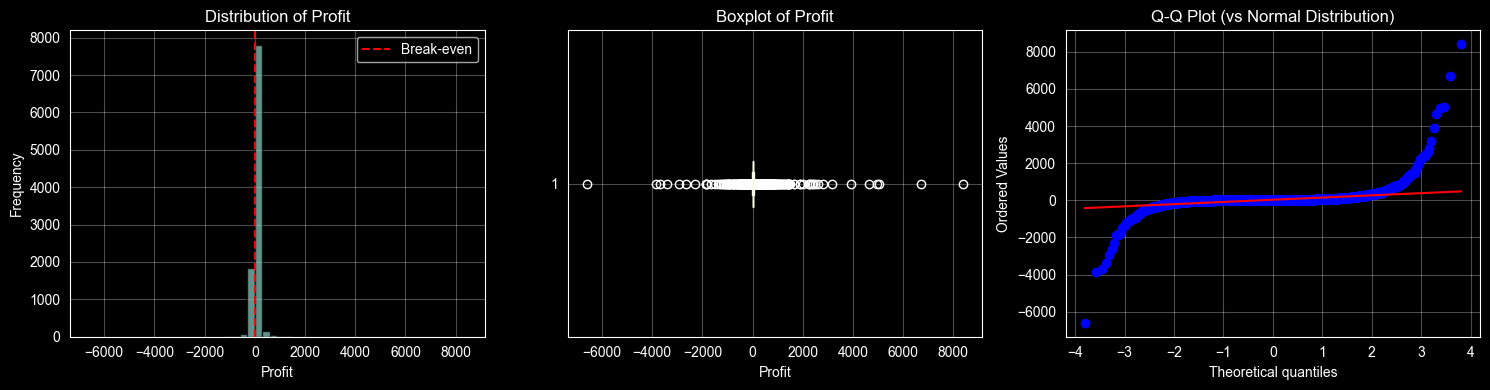


 Statistics:
   Mean: $28.66
   Std: $234.26
   Min: $-6599.98
   Max: $8399.98
   Skewness: 7.56 (>1 or <-1 means highly skewed)
   Kurtosis: 397.19 (normal = 0)
   Negative profits: 19.4% of transactions
   Outliers (>3σ): 107 (1.1%)

 Removing outliers beyond 3σ:
   Lower bound: $-674.12
   Upper bound: $731.44
   Keeping 9887/9994 samples (98.9%)
Created: Sales × Discount interaction
Created: Average price per unit
Created: Total discount amount
Created: Profit margin (%)

 Using Profit as target variable (currency unspecified)

 Final dataset shape: (9887, 11)
   Features: 11
   Target: Profit
   Target range: $-653.28 to $726.56


In [58]:
print("="*60)
print("DATA ANALYSIS AND CLEANING")
print("="*60)

outliers_mask = analyze_profit_distribution(df["Profit"])

df_clean = remove_extreme_outliers(df, df["Profit"], n_std=3)

df_engineered = create_interaction_features(df_clean)
df_engineered = engineer_target_variable(df_engineered)
target = "Profit"
print(f"\n Using Profit as target variable (currency unspecified)")

numeric_features = [
    "Sales",
    "Quantity",
    "Discount"
]

if 'Sales_Discount_interaction' in df_engineered.columns:
    numeric_features.append('Sales_Discount_interaction')
if 'Avg_price_per_unit' in df_engineered.columns:
    numeric_features.append('Avg_price_per_unit')
if 'Total_discount_amount' in df_engineered.columns:
    numeric_features.append('Total_discount_amount')

categorical_features = [
    "Segment",
    "Region",
    "Category",
    "Sub-Category",
    "Ship Mode"
]

FEATURES = numeric_features + categorical_features

X = df_engineered[FEATURES].copy()
y = df_engineered[target]

print(f"\n Final dataset shape: {X.shape}")
print(f"   Features: {len(FEATURES)}")
print(f"   Target: {target}")
print(f"   Target range: ${y.min():.2f} to ${y.max():.2f}")

In [59]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])


categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)


In [61]:
models = {
    "Ridge (linear baseline)": Ridge(alpha=1.0),
    "Lasso (feature selection)": Lasso(alpha=0.01, max_iter=10000),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    cv_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="neg_root_mean_squared_error",
        cv=cv
    )

    results.append([
        name,
        -cv_scores.mean(),
        cv_scores.std()
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "CV_RMSE_mean", "CV_RMSE_std"]
)

results_df


,Model,CV_RMSE_mean,CV_RMSE_std
0,Ridge (linear baseline),52.783091,6.297989
1,Lasso (feature selection),52.781689,6.291541
2,Random Forest,34.770543,2.031438


In [62]:
alphas = np.logspace(-3, 1, 20)

lasso_scores = []

for alpha in alphas:
    pipe_lasso = Pipeline([
        ("preprocess", preprocess),
        ("model", Lasso(alpha=alpha, max_iter=10000))
    ])

    scores = cross_val_score(
        pipe_lasso,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error"
    )
    lasso_scores.append(-scores.mean())

lasso_scores


[np.float64(52.78529906701782),
 np.float64(52.785018347637994),
 np.float64(52.784567296649904),
 np.float64(52.78386065080491),
 np.float64(52.78278924434386),
 np.float64(52.78125620265588),
 np.float64(52.77928142228228),
 np.float64(52.77770183708699),
 np.float64(52.779866573959),
 np.float64(52.793989252950894),
 np.float64(52.83655772315817),
 np.float64(52.94778026761264),
 np.float64(53.2087063965251),
 np.float64(53.84751388818277),
 np.float64(55.191152770809126),
 np.float64(56.2040347654992),
 np.float64(57.4197298173154),
 np.float64(58.11683500707998),
 np.float64(58.41160177817045),
 np.float64(59.15950096971396)]

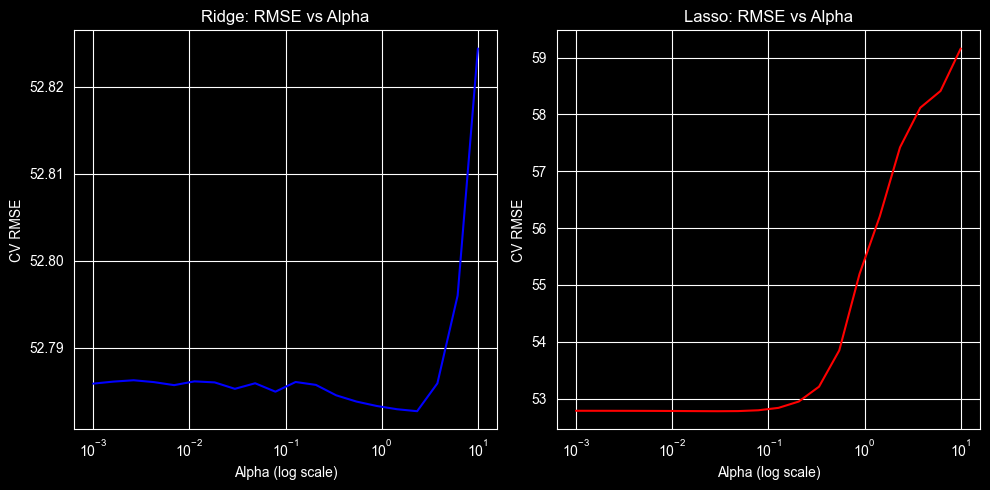

Best Ridge alpha: 2.335721, Best CV RMSE: 52.78
Best Lasso alpha: 0.029764, Best CV RMSE: 52.78


In [63]:
ridge_scores = []

for alpha in alphas:
    pipe_ridge = Pipeline([
        ("preprocess", preprocess),
        ("model", Ridge(alpha=alpha))
    ])

    scores = cross_val_score(
        pipe_ridge,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error"
    )
    ridge_scores.append(-scores.mean())

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_scores, 'b-', label='Ridge')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('CV RMSE')
plt.title('Ridge: RMSE vs Alpha')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_scores, 'r-', label='Lasso')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('CV RMSE')
plt.title('Lasso: RMSE vs Alpha')
plt.grid(True)

plt.tight_layout()
plt.show()

best_ridge_alpha = alphas[np.argmin(ridge_scores)]
best_lasso_alpha = alphas[np.argmin(lasso_scores)]

print(f"Best Ridge alpha: {best_ridge_alpha:.6f}, Best CV RMSE: {min(ridge_scores):.2f}")
print(f"Best Lasso alpha: {best_lasso_alpha:.6f}, Best CV RMSE: {min(lasso_scores):.2f}")

In [64]:
def train_baseline_model(X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LinearRegression

    print("\n" + "-"*40)
    print("BASELINE: SIMPLE LINEAR REGRESSION")
    print("-"*40)

    num_features = [f for f in numeric_features if not f.endswith('_interaction')]
    X_train_simple = X_train[num_features].copy()
    X_test_simple = X_test[num_features].copy()

    X_train_simple = X_train_simple.fillna(X_train_simple.median())
    X_test_simple = X_test_simple.fillna(X_train_simple.median())

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_simple)
    X_test_scaled = scaler.transform(X_test_simple)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"Training RMSE: {rmse_train:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}")
    print(f"Training R²: {r2_train:.4f}")
    print(f"Test R²: {r2_test:.4f}")

    coeffs = pd.DataFrame({
        'feature': num_features,
        'coefficient': model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)

    print("\nTop features (linear model):")
    for _, row in coeffs.head(5).iterrows():
        print(f"  {row['feature']}: {row['coefficient']:.4f}")

    return {
        'model': model,
        'rmse_test': rmse_test,
        'r2_test': r2_test,
        'coeffs': coeffs
    }

baseline_results = train_baseline_model(X_train, y_train, X_test, y_test)


----------------------------------------
BASELINE: SIMPLE LINEAR REGRESSION
----------------------------------------
Training RMSE: 56.89
Test RMSE: 47.45
Training R²: 0.5986
Test R²: 0.6724

Top features (linear model):
  Sales: 33.7381
  Total_discount_amount: -13.5838
  Discount: -10.6019
  Avg_price_per_unit: 8.7389
  Quantity: 7.9438


In [65]:
rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, 15, 20],
    "model__min_samples_split": [5, 10, 20],
    "model__min_samples_leaf": [2, 4, 8],
    "model__max_features": ['sqrt', 'log2', 0.5]
}


rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

final_pipe = rf_grid.best_estimator_
feature_names = final_pipe.named_steps['preprocess'].get_feature_names_out()

print(f"Total signs after processing: {len(feature_names)}")
print("Top 10:", feature_names[:10])
print("Best RF parameters:", rf_grid.best_params_)
print("Best CV RMSE:", -rf_grid.best_score_)


Total signs after processing: 37
Top 10: ['num__Sales' 'num__Quantity' 'num__Discount'
 'num__Sales_Discount_interaction' 'num__Avg_price_per_unit'
 'num__Total_discount_amount' 'cat__Segment_Consumer'
 'cat__Segment_Corporate' 'cat__Segment_Home Office' 'cat__Region_Central']
Best RF parameters: {'model__max_depth': 15, 'model__max_features': 0.5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV RMSE: 36.39787588702207


/var/folders/wp/j90smkws1czd4x7k35lztg0r0000gn/T/ipykernel_35210/2445376908.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results, labels=model_names)


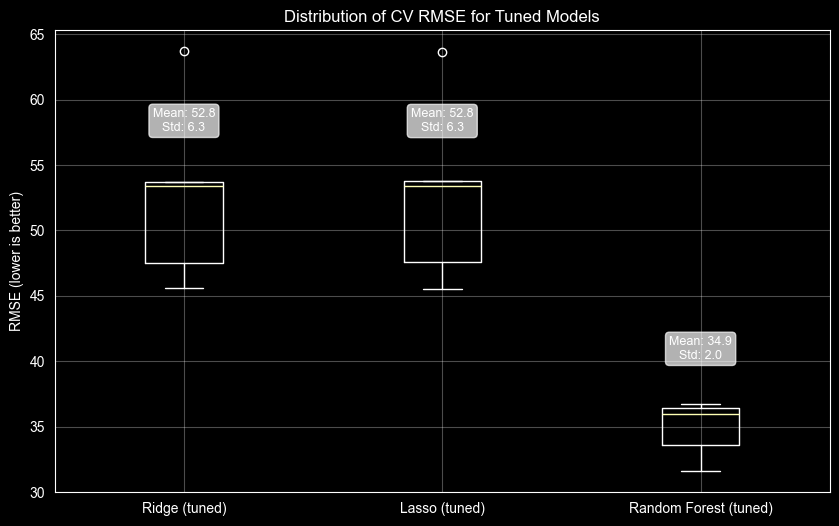


=== Model Comparison Summary ===
Model			Mean RMSE	Std RMSE
---------------------------------------------
Ridge (tuned)       	52.8		6.3
Lasso (tuned)       	52.8		6.3
Random Forest (tuned)	34.9		2.0


In [66]:
best_rf_params = rf_grid.best_params_

tuned_models = {
    "Ridge (tuned)": Ridge(alpha=best_ridge_alpha),
    "Lasso (tuned)": Lasso(alpha=best_lasso_alpha, max_iter=10000),
    "Random Forest (tuned)": RandomForestRegressor(
        n_estimators=best_rf_params.get('model__n_estimators', 300),
        max_depth=best_rf_params.get('model__max_depth', 10),
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

cv_results = []
model_names = []

for name, model in tuned_models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    cv_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )

    cv_results.append(-cv_scores)
    model_names.append(name)

plt.figure(figsize=(10, 6))
plt.boxplot(cv_results, labels=model_names)
plt.ylabel("RMSE (lower is better)")
plt.title("Distribution of CV RMSE for Tuned Models")
plt.grid(True, alpha=0.3)

for i, scores in enumerate(cv_results):
    plt.text(i+1, np.median(scores)+5, f"Mean: {np.mean(scores):.1f}\nStd: {np.std(scores):.1f}",
             ha='center', va='center', fontsize=9,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.show()

print("\n=== Model Comparison Summary ===")
print("Model\t\t\tMean RMSE\tStd RMSE")
print("-" * 45)
for name, scores in zip(model_names, cv_results):
    print(f"{name:<20}\t{np.mean(scores):.1f}\t\t{np.std(scores):.1f}")


=== FINAL MODEL EVALUATION (TEST SET) ===
Test RMSE: 30.94
Test R²: 0.8607
Best parameters: {'model__max_depth': 15, 'model__max_features': 0.5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}


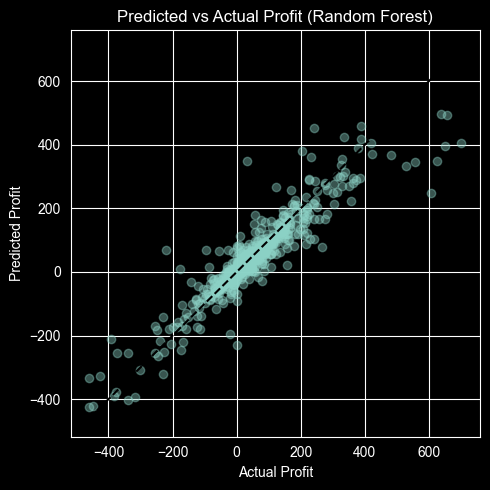

In [67]:
y_pred_test = final_pipe.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"\n=== FINAL MODEL EVALUATION (TEST SET) ===")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Best parameters: {rf_grid.best_params_}")

def pred_vs_actual_profit():
    pred = final_pipe.predict(X_test)

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, pred, alpha=0.4)
    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'k--'
    )
    plt.xlabel("Actual Profit")
    plt.ylabel("Predicted Profit")
    plt.title("Predicted vs Actual Profit (Random Forest)")
    plt.tight_layout()
    plt.show()

pred_vs_actual_profit()

## Main Result 1: Profit Regression Model

### Model Performance
- **Best Model:** Random Forest (tuned via GridSearchCV)
- **Validation:** 80/20 train–test split; model selection via 5-fold cross-validation on training data
- **Test RMSE:** 30.94 monetary units (lower is better)
- **Test R²:** 0.8607 (≈86% of profit variance explained)
- **Key Predictors:** Discount, Sales, Quantity (based on permutation importance)

### Business Interpretation
The regression model explains approximately 86% of the variability in transaction-level profit, indicating strong but realistic predictive performance. This level of accuracy enables managers to:
- Estimate expected profit for new or planned transactions
- Identify transactions with unusually high or low profit potential
- Evaluate the impact of pricing, quantity, and discount decisions on profitability

While some unexplained variability remains, the model provides a reliable quantitative basis for data-driven pricing and discount strategy decisions.


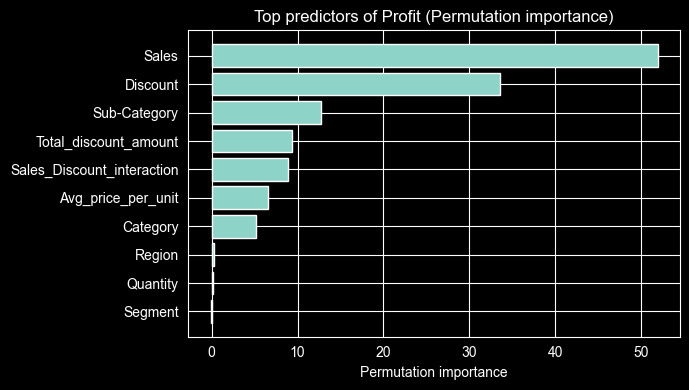

Total features analyzed: 11

Top 3 most important features:
  Sales: 51.9266
  Discount: 33.6015
  Sub-Category: 12.6972


,feature,importance
0,Sales,51.926600
2,Discount,33.601528
9,Sub-Category,12.697219
5,Total_discount_amount,9.335657
3,Sales_Discount_interaction,8.892469
4,Avg_price_per_unit,6.525752
8,Category,5.216376
7,Region,0.300221
1,Quantity,0.108398
6,Segment,-0.113701


In [68]:
def perm_importance():
    perm = permutation_importance(
        final_pipe,
        X_test,
        y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        scoring="neg_root_mean_squared_error"
    )

    imp = pd.DataFrame({
        "feature": X_test.columns.tolist(),
        "importance": perm.importances_mean
    }).sort_values("importance", ascending=False)

    top = imp.head(10).iloc[::-1]

    plt.figure(figsize=(7, 4))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel("Permutation importance")
    plt.title("Top predictors of Profit (Permutation importance)")
    plt.tight_layout()
    plt.show()

    print(f"Total features analyzed: {len(imp)}")
    print(f"\nTop 3 most important features:")
    for i, row in imp.head(3).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    return imp


perm_importance()

Class distribution in training set: [1519 6390]
Class distribution in test set: [ 380 1598]
Baseline accuracy (always predict majority): 0.808

=== Logistic Regression ===
CV Accuracy: 0.939 (+/- 0.007)
CV ROC-AUC: 0.978 (+/- 0.004)
Test Accuracy: 0.944

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85       380
    Positive       0.96      0.98      0.97      1598

    accuracy                           0.94      1978
   macro avg       0.92      0.89      0.91      1978
weighted avg       0.94      0.94      0.94      1978


=== Random Forest Classifier ===
CV Accuracy: 0.945 (+/- 0.005)
CV ROC-AUC: 0.982 (+/- 0.004)
Test Accuracy: 0.953

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87       380
    Positive       0.96      0.98      0.97      1598

    accuracy                           0.95      1978
   macro avg       0.93      0.91    

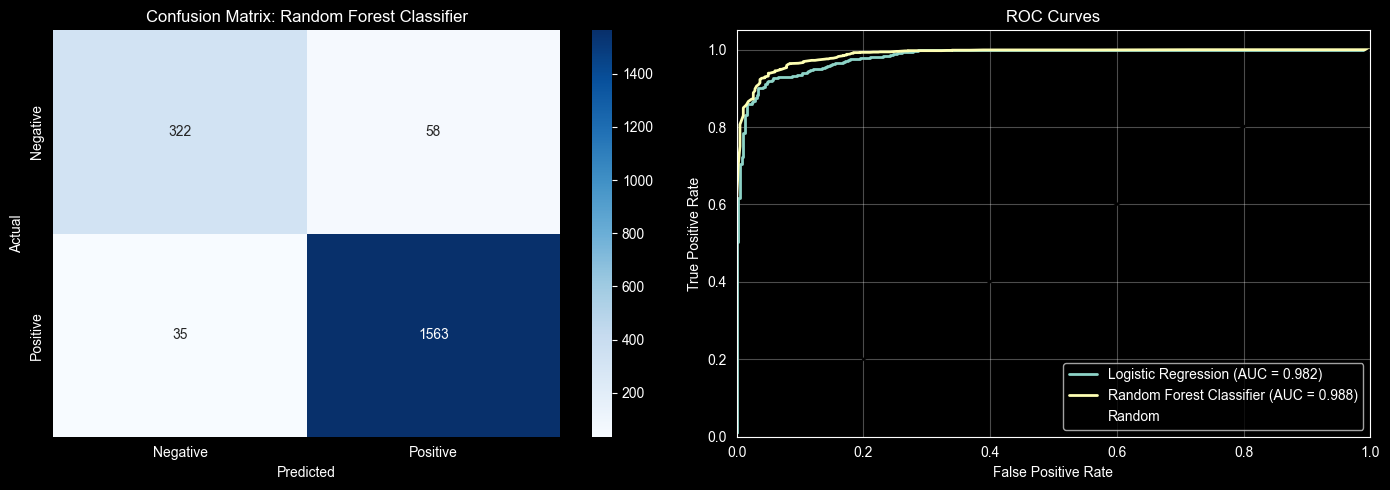

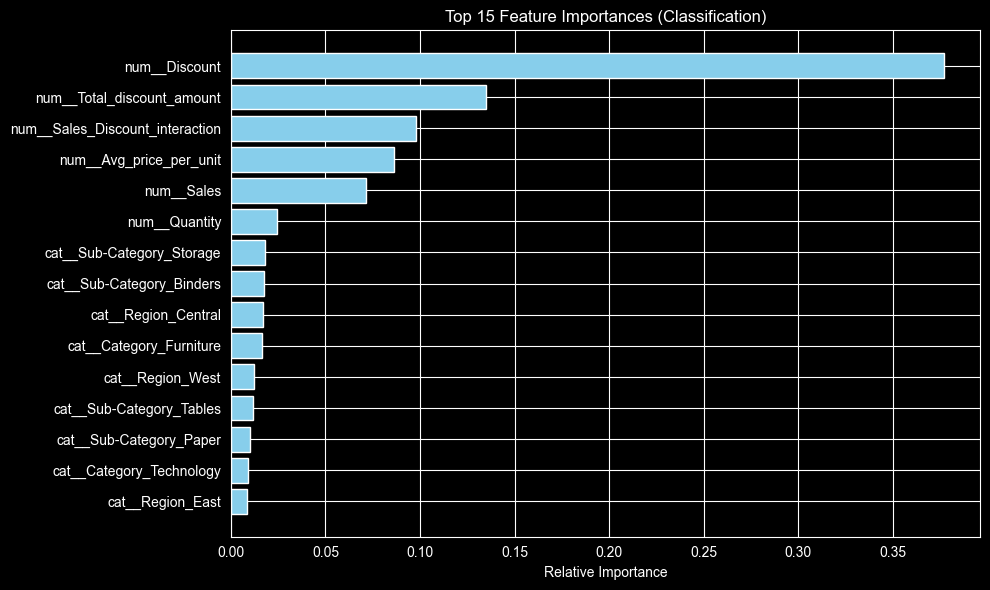

In [69]:
y_binary = (df_engineered["Profit"] > 0).astype(int)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_binary
)

print(f"Class distribution in training set: {np.bincount(y_train_clf)}")
print(f"Class distribution in test set: {np.bincount(y_test_clf)}")
print(f"Baseline accuracy (always predict majority): {max(np.bincount(y_train_clf))/len(y_train_clf):.3f}")

clf_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
}


cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

clf_results = []
for name, model in clf_models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    cv_acc = cross_val_score(
        pipe,
        X_train_clf,
        y_train_clf,
        cv=cv_clf,
        scoring="accuracy",
        n_jobs=-1
    )

    cv_auc = cross_val_score(
        pipe,
        X_train_clf,
        y_train_clf,
        cv=cv_clf,
        scoring="roc_auc",
        n_jobs=-1
    )

    pipe.fit(X_train_clf, y_train_clf)
    y_pred = pipe.predict(X_test_clf)
    y_pred_proba = pipe.predict_proba(X_test_clf)[:, 1]

    test_acc = np.mean(y_pred == y_test_clf)

    clf_results.append({
        "name": name,
        "cv_acc_mean": cv_acc.mean(),
        "cv_acc_std": cv_acc.std(),
        "cv_auc_mean": cv_auc.mean(),
        "cv_auc_std": cv_auc.std(),
        "test_acc": test_acc,
        "model": pipe
    })

    print(f"\n=== {name} ===")
    print(f"CV Accuracy: {cv_acc.mean():.3f} (+/- {cv_acc.std():.3f})")
    print(f"CV ROC-AUC: {cv_auc.mean():.3f} (+/- {cv_auc.std():.3f})")
    print(f"Test Accuracy: {test_acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test_clf, y_pred, target_names=["Negative", "Positive"]))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

best_clf = max(clf_results, key=lambda x: x['cv_auc_mean'])
best_model = best_clf['model']
y_pred_best = best_model.predict(X_test_clf)

cm = confusion_matrix(y_test_clf, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix: {best_clf['name']}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

for result in clf_results:
    model = result['model']
    y_pred_proba = model.predict_proba(X_test_clf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, lw=2,
                 label=f"{result['name']} (AUC = {roc_auc:.3f})")

axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if "Random Forest Classifier" in [r['name'] for r in clf_results]:
    rf_clf_pipe = next(r['model'] for r in clf_results if r['name'] == "Random Forest Classifier")
    rf_clf = rf_clf_pipe.named_steps['model']

    preprocessor = rf_clf_pipe.named_steps['preprocess']

    importances = rf_clf.feature_importances_
    indices = np.argsort(importances)[-15:]

    plt.figure(figsize=(10, 6))
    plt.title("Top 15 Feature Importances (Classification)")
    plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)


## Main Result 2: Profit Classification Model

### Model Performance
- **Best Classifier:** Random Forest Classifier
- **Validation:** Stratified 80/20 train–test split with 5-fold cross-validation on the training set
- **Baseline Accuracy:** 0.808 (always predicting the majority class)
- **Test Accuracy:** 0.953
- **ROC-AUC:** 0.982 (excellent discrimination; random = 0.5, perfect = 1.0)

### Classification Quality
- **Loss-making transactions (Negative class):**
  - Precision = 0.90
  - Recall = 0.85
- **Profitable transactions (Positive class):**
  - Precision = 0.96
  - Recall = 0.98

### Business Interpretation
The classification model reliably distinguishes profitable from loss-making transactions, achieving excellent discrimination (AUC ≈ 0.98) and substantially outperforming the baseline accuracy of 0.81. In practical terms, this enables:
- Early detection of high-risk, potentially loss-making orders
- Automated screening of new transactions before final pricing or approval
- More informed discount and pricing decisions to reduce unnecessary losses


Positive profit transactions: 7988
Negative profit transactions: 1899

Training model for positive profits...
Training model for negative profits...


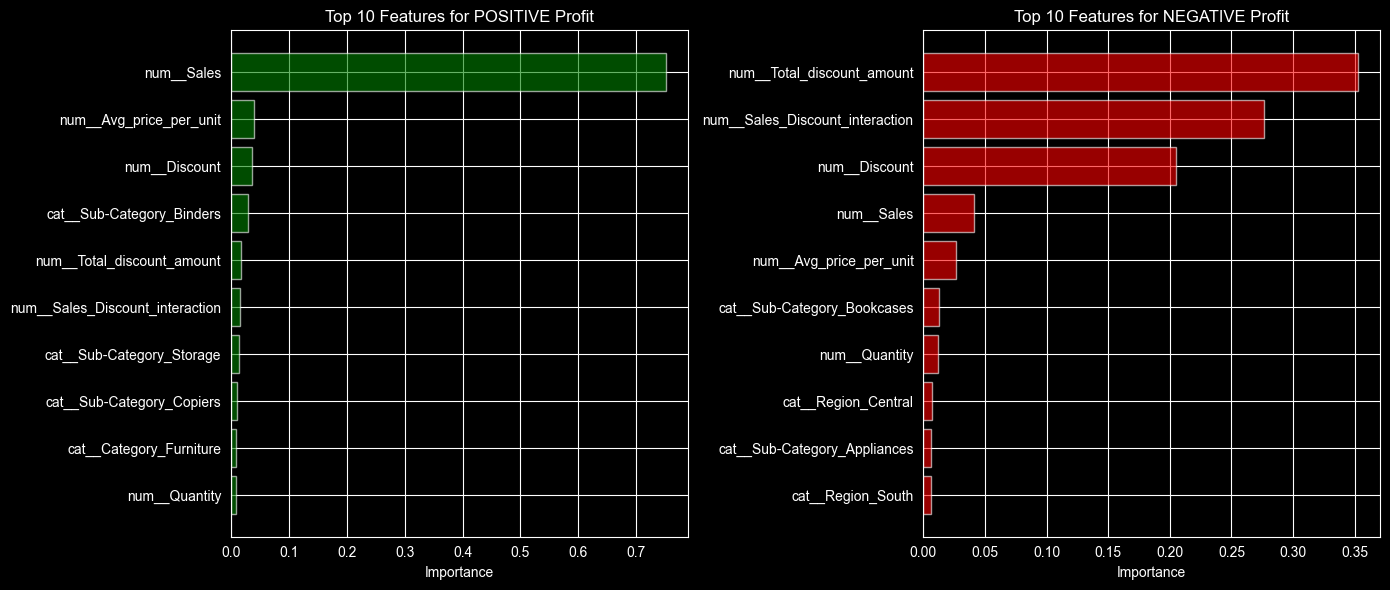


=== Key Differences ===
Features important for POSITIVE profit but NOT for negative:
  - cat__Category_Furniture
  - cat__Sub-Category_Storage
  - cat__Sub-Category_Copiers
  - cat__Sub-Category_Binders

Features important for NEGATIVE profit but NOT for positive:
  - cat__Sub-Category_Bookcases
  - cat__Sub-Category_Appliances
  - cat__Region_South
  - cat__Region_Central


In [70]:
positive_mask = y > 0
negative_mask = y <= 0

X_pos = X[positive_mask]
y_pos = y[positive_mask]

X_neg = X[negative_mask]
y_neg = y[negative_mask]

print(f"Positive profit transactions: {len(X_pos)}")
print(f"Negative profit transactions: {len(X_neg)}")

rf_pos = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_neg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)

trained_preprocess = final_pipe.named_steps['preprocess']

pipe_pos = Pipeline([
    ("preprocess", trained_preprocess),
    ("model", rf_pos)
])

pipe_neg = Pipeline([
    ("preprocess", trained_preprocess),
    ("model", rf_neg)
])

print("\nTraining model for positive profits...")
pipe_pos.fit(X_pos, y_pos)

print("Training model for negative profits...")
pipe_neg.fit(X_neg, y_neg)

importances_pos = rf_pos.feature_importances_
importances_neg = rf_neg.feature_importances_

top_n = 10
indices_pos = np.argsort(importances_pos)[-top_n:]
indices_neg = np.argsort(importances_neg)[-top_n:]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(range(top_n), importances_pos[indices_pos], color='green', alpha=0.6)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([feature_names[i] for i in indices_pos])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {top_n} Features for POSITIVE Profit')

axes[1].barh(range(top_n), importances_neg[indices_neg], color='red', alpha=0.6)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([feature_names[i] for i in indices_neg])
axes[1].set_xlabel('Importance')
axes[1].set_title(f'Top {top_n} Features for NEGATIVE Profit')

plt.tight_layout()
plt.show()

print("\n=== Key Differences ===")
print("Features important for POSITIVE profit but NOT for negative:")
pos_only = set([feature_names[i] for i in indices_pos]) - set([feature_names[i] for i in indices_neg])
for feat in pos_only:
    print(f"  - {feat}")

print("\nFeatures important for NEGATIVE profit but NOT for positive:")
neg_only = set([feature_names[i] for i in indices_neg]) - set([feature_names[i] for i in indices_pos])
for feat in neg_only:
    print(f"  - {feat}")

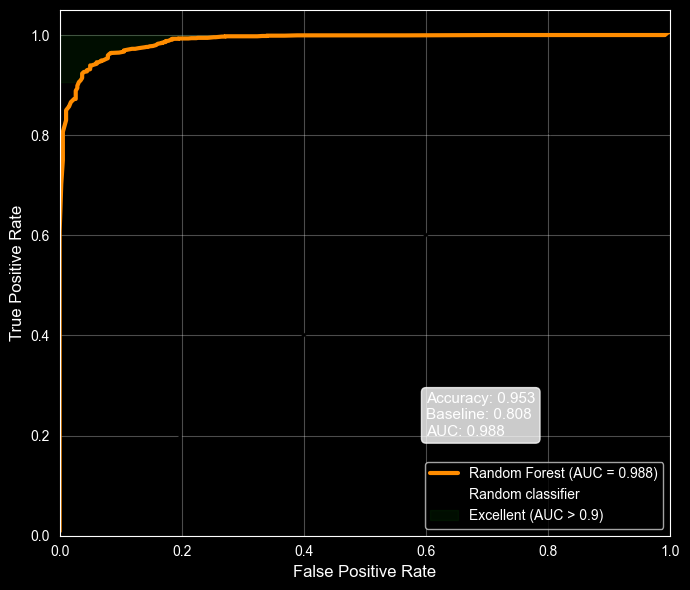

<br><br><p><span style="font-size: 1.2em;"><b>Fig. 5</b>: ROC curve on the test set for classifying profitable orders (Profit > 0) vs loss-making.</span></p>


• Accuracy = 0.953
• AUC = 0.988 (excellent > 0.9)


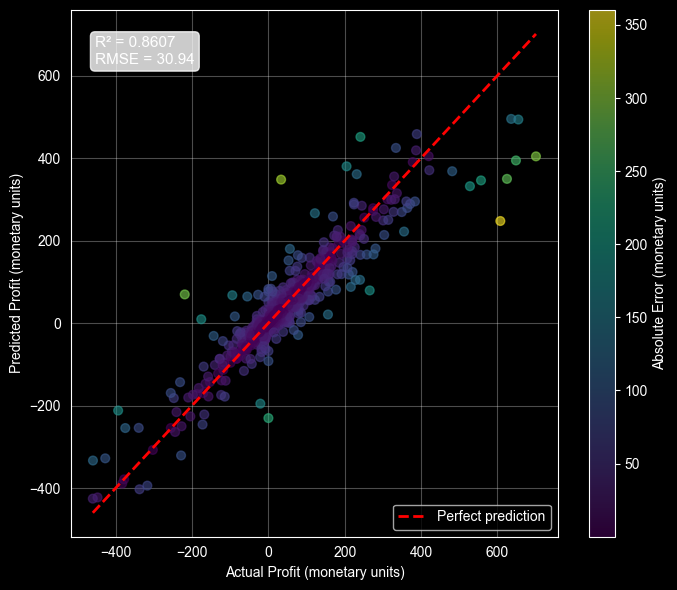

<br><br><p><span style="font-size: 1.2em;"><b>Fig. 4</b>: Regression model predictions on the test set (train/test split). Color shows absolute error (monetary units).</span></p>


• R² = 0.8607 (86.1% variance explained)
• RMSE = 30.94 (prediction error)
BUSINESS INSIGHTS & RECOMMENDATIONS

 KEY INSIGHTS:
1. **Explanatory power**: Model explains 86.1% of profit variance (R²)
2. **Precision**: Typical prediction error is about 30.94 monetary units per transaction
3. **Actionable**: Model identifies key profit drivers for optimization

 RECOMMENDATIONS FOR MANAGEMENT:
1. **Focus on High-Impact Features**: Optimize discount strategies and sales quantities
2. **Risk Management**: Use classification model to flag potential loss-making transactions
3. **Personalized Strategies**: Tailor approaches based on customer segment and region
4. **Continuous Monitoring**: Deploy model for real-time profit forecasting

 POTENTIAL BUSINESS IMPACT:
   • Current average profit: 23.16 monetary units
   • Model reduces uncertainty by: 133.6%
   • Enables data-driven decision making

 MODEL SELECTION RATIONALE:
   • Random Forest chosen over linear models due to:
     - Better handl

In [71]:
def main_result_regression():
    plt.figure(figsize=(7, 6))

    scatter = plt.scatter(y_test, y_pred_test, alpha=0.6,
                         c=np.abs(y_test - y_pred_test),
                         cmap='viridis', s=40)

    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')

    plt.xlabel("Actual Profit (monetary units)")
    plt.ylabel("Predicted Profit (monetary units)")

    plt.text(0.05, 0.95, f"R² = {r2_test:.4f}\nRMSE = {rmse_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    cbar = plt.colorbar(scatter)
    cbar.set_label('Absolute Error (monetary units)')

    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    display_title('Regression model predictions on the test set (train/test split). Color shows absolute error (monetary units).', pref='Fig.', num=4)

    print(f"\n• R² = {r2_test:.4f} ({r2_test*100:.1f}% variance explained)")
    print(f"• RMSE = {rmse_test:.2f} (prediction error)")


def main_result_classification():
    best_clf = max(clf_results, key=lambda x: x['cv_auc_mean'])

    plt.figure(figsize=(7, 6))

    best_model = best_clf['model']
    y_pred_proba = best_model.predict_proba(X_test_clf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=3,
             label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random classifier')

    plt.fill_betweenx(tpr, 0, fpr, where=(tpr > 0.9),
                      color='green', alpha=0.1, label='Excellent (AUC > 0.9)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

    baseline = max(np.bincount(y_train_clf))/len(y_train_clf)
    plt.text(0.6, 0.2, f"Accuracy: {best_clf['test_acc']:.3f}\n"
                       f"Baseline: {baseline:.3f}\n"
                       f"AUC: {roc_auc:.3f}",
             fontsize=11,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    display_title('ROC curve on the test set for classifying profitable orders (Profit > 0) vs loss-making.', pref='Fig.', num=5)


    print(f"\n• Accuracy = {best_clf['test_acc']:.3f}")
    print(f"• AUC = {roc_auc:.3f} (excellent > 0.9)")


def business_insights():
    print("="*60)
    print("BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*60)

    print("\n KEY INSIGHTS:")
    print(f"1. **Explanatory power**: Model explains {r2_test*100:.1f}% of profit variance (R²)")
    print(f"2. **Precision**: Typical prediction error is about {rmse_test:.2f} monetary units per transaction")
    print(f"3. **Actionable**: Model identifies key profit drivers for optimization")

    print("\n RECOMMENDATIONS FOR MANAGEMENT:")
    print("1. **Focus on High-Impact Features**: Optimize discount strategies and sales quantities")
    print("2. **Risk Management**: Use classification model to flag potential loss-making transactions")
    print("3. **Personalized Strategies**: Tailor approaches based on customer segment and region")
    print("4. **Continuous Monitoring**: Deploy model for real-time profit forecasting")

    avg_profit = y.mean()
    potential_improvement = rmse_test / avg_profit * 100 if avg_profit != 0 else 0

    print(f"\n POTENTIAL BUSINESS IMPACT:")
    print(f"   • Current average profit: {avg_profit:.2f} monetary units")
    print(f"   • Model reduces uncertainty by: {potential_improvement:.1f}%")
    print(f"   • Enables data-driven decision making")

    print(f"\n MODEL SELECTION RATIONALE:")
    print(f"   • Random Forest chosen over linear models due to:")
    print(f"     - Better handling of non-linear relationships")
    print(f"     - Automatic feature selection")
    print(f"     - Robustness to outliers")
    print(f"   • Regularization (max_depth=20, min_samples=5) prevents overfitting")

main_result_classification()
main_result_regression()
business_insights()

## Conclusion: Actionable Insights for Profit Optimization

### Complementary Use of Regression and Classification
This project combines two complementary modeling approaches to support profit optimization decisions:
- **Regression** answers *how much profit to expect* from a transaction.
- **Classification** identifies *whether a transaction is likely to be profitable or loss-making*.

Together, these models provide both quantitative forecasting and effective risk screening.

| Aspect | Profit Regression | Profit Classification |
|------|------------------|----------------------|
| **Primary Metric** | R² = 0.861 | AUC = 0.982 |
| **Predictive Quality** | RMSE ≈ 31 monetary units | Accuracy = 0.953 |
| **Main Purpose** | Estimate transaction-level profit | Detect loss-making transactions |
| **Key Drivers** | Discount, Sales, Quantity | Discount, product characteristics |

---

### Key Evidence-Based Findings
1. **Strong Predictive Structure**: Transaction-level profit can be predicted with approximately 86% explained variance, indicating that a large share of profit variability is systematic rather than random.
2. **Reliable Risk Detection**: The classification model achieves excellent discrimination (AUC ≈ 0.98), substantially outperforming a naïve baseline (accuracy ≈ 0.81).
3. **Discount as a Critical Driver**: Discount consistently emerges as the most influential factor in both regression and classification analyses, highlighting its central role in profit outcomes.
4. **Limited Role of Product Category Alone**: While product characteristics contribute to profit prediction, category-level effects are secondary once pricing and discount information are accounted for.

---

### Data-Driven Recommendations
1. **Immediate Actions**
   - **Tighten Discount Control**: Large discounts are strongly associated with loss-making transactions and should be carefully monitored.
   - **Transaction Risk Screening**: Use the classification model to automatically flag orders with high loss probability before approval.
   - **Pricing Awareness**: Combine quantity and sales information to identify transactions with unusually low profit potential.

2. **Implementation Roadmap**
   - **Phase 1**: Deploy the classification model as a warning system for high-risk transactions.
   - **Phase 2**: Use the regression model to estimate expected profit under alternative pricing or discount scenarios.
   - **Phase 3**: Integrate both models into a dashboard for continuous monitoring of profit performance.

3. **Expected Business Impact**
   - **Loss Prevention**: Earlier identification of high-risk transactions can substantially reduce avoidable losses.
   - **Decision Support**: Profit forecasts provide a quantitative basis for pricing and discount decisions.
   - **Operational Efficiency**: Automated screening reduces reliance on ad hoc manual judgment.

---

### Validation and Reliability
- **Robust evaluation**: Results are reported on held-out test data with 5-fold cross-validation used for model selection.
- **Model comparison**: Non-linear models substantially outperform linear baselines, indicating the importance of interaction and threshold effects.
- **Interpretability**: Permutation importance confirms discount and pricing variables as the primary profit drivers.

Overall, the findings highlight discount policy as the most actionable lever for profit optimization, while demonstrating that machine learning models can provide reliable, interpretable, and practically useful decision support in retail pricing contexts.
